# Shalev Wiseman Notebook

## Objective

### The main objectives of this notebook are as follows:

**1. Data Ingestion:** 
Read the FHIR-formatted patient encounter data into a structured format that can be easily manipulated and queried.

**2. Database Creation:** 
Design and create a database schema that aligns with the FHIR data structure, ensuring the data is stored in a way that is both efficient and query-friendly.

**3. Data Insertion:**
Populate the database tables with the FHIR data, ensuring data integrity and consistency.

**4. Data Querying:** 
Develop and execute a series of SQL queries that perform simple aggregative functions on the data.

### Structure of the Notebook
The notebook is structured into several sections, with each one focusing on a specific aspect of the task at hand. I will begin by setting up the environment, then proceed to design the database schema, create the necessary tables, and insert the data. Finally, I will write and execute the SQL queries.

In [1]:
import sqlite3
import pandas as pd
import json
from datetime import datetime

In [2]:
conn = sqlite3.connect('encounters_data.db')
cursor = conn.cursor()

In [3]:
# Read the entire content of the JSONL file as a single string
with open('fhir_encounters.jsonl', 'r') as file:
    data_str = file.read()

# Split the string into individual JSON objects
json_objects = data_str.split('}\n{')
json_objects[0] = json_objects[0][1:]
json_objects[-1] = json_objects[-1][:-1]                                       

# Database Schema Design

## Overview

My database schema is designed to efficiently store and manage healthcare encounter data. The schema adheres to the Third Normal Form (3NF) to ensure minimal redundancy and data integrity. The design includes five key tables: `Patients`, `Practitioners`, `Locations`, `Diagnosis`, and `Encounter`. Each table is structured to hold specific pieces of information, which are interconnected through various relationships.

## Tables and Relationships

### 1. Patients Table

- **Table Name**: `Patients`
- **Description**: Stores information about patients.
- **Columns**:
  - `patient_id` (Primary Key): A unique identifier for each patient.
  - `patient_name` The name of the patient.

### 2. Practitioners Table

- **Table Name**: `Practitioners`
- **Description**: Contains details about healthcare practitioners.
- **Columns**:
  - `practitioner_id` (Primary Key): A unique identifier for each practitioner.
  - `practitioner_name` The name of the practitioner.

### 3. Locations Table

- **Table Name**: `Locations`
- **Description**: Captures information about the locations where encounters occur.
- **Columns**:
  - `location_id` (Primary Key): A unique identifier for each location.
  - `description`  A description of the location.

### 4. Diagnosis Table

- **Table Name**: `Diagnosis`
- **Description**: Holds diagnostic information.
- **Columns**:
  - `diagnosis_code` (Primary Key): A unique code for each diagnosis.
  - `description`     A description of the diagnosis.
  - `system`          The coding system used for the diagnosis.

### 5. Encounter Table

- **Table Name**: `Encounter`
- **Description**: Records details of each patient encounter.
- **Columns**:
  - `encounter_id` (Primary Key, Autoincrement): A unique identifier for each encounter.
  - `patient_id` Identifier for the patient involved in the encounter (Foreign Key referencing `Patients`).
  - `practitioner_id`  Identifier for the practitioner involved in the encounter (Foreign Key referencing `Practitioners`).
  - `start`  The start date of the encounter.
  - `end`  The end date of the encounter.
  - `location_id`  Identifier for the location of the encounter (Foreign Key referencing `Locations`).
  - `diagnosis_code` Diagnosis code related to the encounter (Foreign Key referencing `Diagnosis`).
  - **Constraints**:
    - Unique constraint on (`patient_id`, `practitioner_id`, `start`) to avoid duplicate entries.
    - Foreign key constraints to maintain referential integrity.






## Schema Diagram:  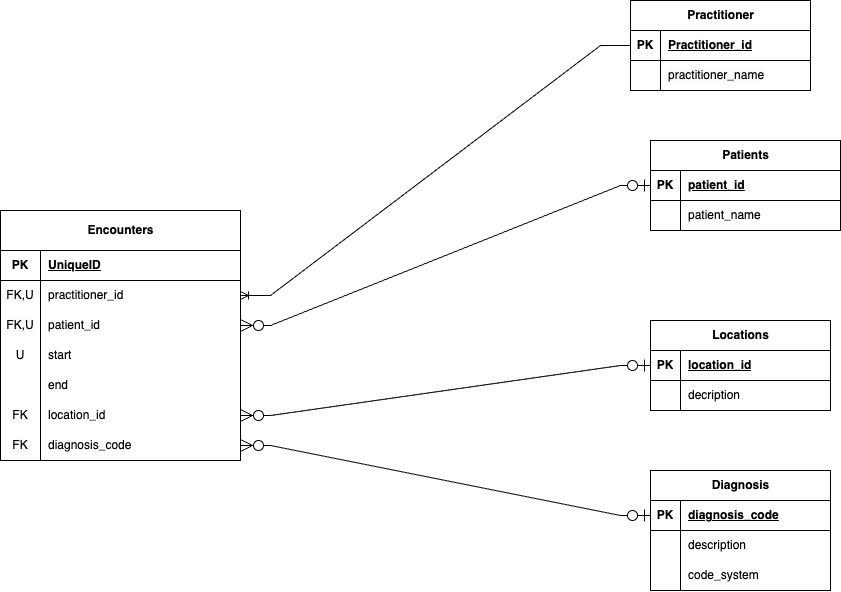

## Normalization Principles Applied to Our Schema

In designing the database schema for our healthcare data, I have closely followed the principles of the Third Normal Form (3NF) to ensure data integrity and reduce redundancy.

For the `Patients`, `Practitioners`, `Locations`, and `Diagnosis` tables, I applied 3NF by isolating specific types of information into these separate tables, each with its unique primary key (`patient_id`, `practitioner_id`, `location_id`, and `diagnosis_code` respectively). This structure ensures that details specific to patients, practitioners, locations, and diagnoses are stored only once, thereby eliminating data duplication. It also ensures that the data in each of these tables is directly related to its primary key, adhering to the principle of full functional dependency, a core aspect of 3NF. By maintaining this separation, updates, deletions, or insertions in one aspect of the data (like a practitioner's details or a diagnosis description) do not necessitate widespread changes across the database.

For the `Encounter` table, the core of the schema, the Encounter table, links `patients`, `practitioners`, `locations`, and `diagnoses`. By using foreign keys referencing the primary keys of the other tables, I maintain the integrity of relationships and ensure that the encounter data is fully functionally dependent only on its own primary key, `encounter_id`. The combination of `patient_id`, `practitioner_id`, and `start` as a unique constraint ensures each encounter is distinct and prevents duplication.



# Table Creation:

In [4]:
# Create Patients Table
cursor.execute('''
CREATE TABLE IF NOT EXISTS Patients (
    patient_id TEXT PRIMARY KEY,
    patient_name TEXT NOT NULL
);
''')

In [5]:
# Create Practitioner Table
cursor.execute('''
CREATE TABLE IF NOT EXISTS Practitioners (
    practitioner_id TEXT PRIMARY KEY,
    practitioner_name TEXT NOT NULL
);
''')

In [6]:
# Create Locations Table
cursor.execute('''
CREATE TABLE IF NOT EXISTS Locations (
    location_id TEXT PRIMARY KEY,
    description TEXT
);

''')

In [7]:
# Create Diagnosis Table
cursor.execute('''
CREATE TABLE IF NOT EXISTS Diagnosis (
    diagnosis_code TEXT PRIMARY KEY,
    description TEXT,
    system TEXT
);

''')

In [8]:
# Create Encounters Table
cursor.execute('''
CREATE TABLE IF NOT EXISTS Encounter (
    encounter_id INTEGER PRIMARY KEY AUTOINCREMENT,
    patient_id TEXT,
    practitioner_id TEXT,
    start DATE,
    end DATE,
    location_id TEXT,
    diagnosis_code TEXT,
    UNIQUE(patient_id, practitioner_id, start),
    FOREIGN KEY(patient_id) REFERENCES Patients(patient_id),
    FOREIGN KEY(practitioner_id) REFERENCES Practitioners(practitioner_id),
    FOREIGN KEY(location_id) REFERENCES Locations(location_id),
    FOREIGN KEY(diagnosis_code) REFERENCES Diagnosis(diagnosis_code)
);
''')

# Data Insertion:

In [9]:
for jsn in json_objects:
    json_str = jsn
    json_data = json.loads('{' + json_str + '}')
    encounters_array = json_data["encounter"]["entry"]
    for encounter in encounters_array:
        
        if encounter["resource"]["resourcetype"] == "Encounter":
            ################Patients################
            patient_id = encounter["resource"]["subject"]["reference"]
            patient_name = encounter["resource"]["subject"]["display"]
            # Check if patient_id already exists
            cursor.execute("SELECT 1 FROM Patients WHERE patient_id=?", (patient_id,))
            patient_exists = cursor.fetchone()


            if not patient_exists:
                # Insert data into the Patients table
                cursor.execute('''
                    INSERT INTO Patients (patient_id, patient_name)
                    VALUES (?, ?)
                ''', (patient_id, patient_name))
            
            ################practitioner################
            participant_array = encounter["resource"]["participant"]
            size = len(participant_array)
            if size > 0:
                practitioner_name = participant_array[-1]['display']
                practitioner_id = participant_array[-1]['reference']
            # Check if practitioner_id already exists
            cursor.execute("SELECT 1 FROM Practitioners WHERE practitioner_id=?", (practitioner_id,))
            practitioner_exists = cursor.fetchone()
            if not practitioner_exists:
                # Insert data into the Practitioners table
                cursor.execute('''
                    INSERT INTO Practitioners (practitioner_id, practitioner_name)
                    VALUES (?, ?)
                ''', (practitioner_id, practitioner_name))
            
            ################Locations################
            location_id = encounter["resource"]["location"][0]["location"]["reference"]
            description = encounter["resource"]["location"][0]["location"]["display"]
            # Check if location_id already exists
            cursor.execute("SELECT 1 FROM Locations WHERE location_id=?", (location_id,))
            location_exists = cursor.fetchone()
            if not location_exists:
                # Insert data into the Locations table
                cursor.execute('''
                    INSERT INTO Locations (location_id, description)
                    VALUES (?, ?)
                ''', (location_id, description))
                
            ################Diagnosis################
            description = encounter["resource"]["diagnosis"]["display"].split(', ')[0]
            diagnosis_code = encounter["resource"]["diagnosis"]["reference"]
            system = encounter["resource"]["diagnosis"]["system"]
            # Check if diagnosis_code already exists
            cursor.execute("SELECT 1 FROM Diagnosis WHERE diagnosis_code=?", (diagnosis_code,))
            diagnosis_exists = cursor.fetchone()
            if not diagnosis_exists:
                # Insert data into the Diagnosis table
                cursor.execute('''
                    INSERT INTO Diagnosis (diagnosis_code, description, system)
                    VALUES (?, ?, ?)
                ''', (diagnosis_code, description, system))
            
            ################Encounters################
            start = encounter["resource"]["period"]["start"]
            end = encounter["resource"]["period"]["_end"]
            # Check if the key already exists
            cursor.execute('''
                SELECT *
                FROM Encounter
                WHERE practitioner_id = ? AND patient_id = ? AND start = ?
            ''', (practitioner_id, patient_id, start))

            existing_record = cursor.fetchone()
            if not existing_record:
                # Insert data into the Patients table
                cursor.execute('''
                    INSERT INTO Encounter (practitioner_id, patient_id, start, end, location_id, diagnosis_code)
                    VALUES (?, ?, ?, ?, ?, ?)
                ''', (practitioner_id, patient_id, start, end, location_id, diagnosis_code))

In [10]:
Patients_table = pd.read_sql_query("SELECT * FROM Patients", conn)
Patients_table.head(5)

,patient_id,patient_name
0,Patient3015,Lily Young
1,Patient3026,Oliver White
2,Patient3007,William Taylor
3,Patient3008,Emma Anderson
4,Patient3025,Grace Walker


In [11]:
Practitioners_table = pd.read_sql_query("SELECT * FROM Practitioners", conn)
Practitioners_table.head(5)

,practitioner_id,practitioner_name
0,Practitioner/Dr2002,Dr. Benjamin Carter
1,Practitioner/Dr2005,Dr. Sophia Garcia
2,Practitioner/Dr2003,Dr. Olivia Davis
3,Practitioner/Dr2001,Dr. Emily Anderson
4,Practitioner/Dr2004,Dr. Ethan Fisher


In [12]:
Locations_table = pd.read_sql_query("SELECT * FROM Locations", conn)
Locations_table

,location_id,description
0,Location/emFR3fX6yqT.KL--hFHkxMw3,Jade Forest Hospital Center
1,Location/eoZBxDsF8h3swUHVxO0sxlw3,DERM LAC202 CSMG


In [13]:
Diagnosis_table = pd.read_sql_query("SELECT * FROM Diagnosis", conn)
Diagnosis_table.head(5)

,diagnosis_code,description,system
0,F32.A,Depression,ICD-CM-9
1,J02.9,Acute pharyngitis,ICD-CM-9
2,F41.9,Anxiety disorder,ICD-CM-9
3,R30.0,Dysuria,ICD-CM-11
4,F41.1,Generalized anxiety disorder,ICD-CM-10


In [14]:
Encounter_table = pd.read_sql_query("SELECT * FROM Encounter", conn)
Encounter_table.head(10)

,encounter_id,patient_id,practitioner_id,start,end,location_id,diagnosis_code
0,1,Patient3015,Practitioner/Dr2002,2023-11-22T03:00:00Z,2023-11-22T03:15:00Z,Location/emFR3fX6yqT.KL--hFHkxMw3,F32.A
1,2,Patient3026,Practitioner/Dr2005,2023-11-22T03:00:00Z,2023-11-22T03:15:00Z,Location/emFR3fX6yqT.KL--hFHkxMw3,J02.9
2,3,Patient3007,Practitioner/Dr2003,2023-11-22T03:00:00Z,2023-11-22T03:15:00Z,Location/emFR3fX6yqT.KL--hFHkxMw3,F41.9
3,4,Patient3008,Practitioner/Dr2003,2023-11-22T03:00:00Z,2023-11-22T03:15:00Z,Location/emFR3fX6yqT.KL--hFHkxMw3,R30.0
4,5,Patient3025,Practitioner/Dr2005,2023-11-22T03:00:00Z,2023-11-22T03:15:00Z,Location/emFR3fX6yqT.KL--hFHkxMw3,F41.1
5,6,Patient3006,Practitioner/Dr2001,2023-11-22T03:00:00Z,2023-11-22T03:15:00Z,Location/emFR3fX6yqT.KL--hFHkxMw3,J01.90
6,7,Patient3002,Practitioner/Dr2003,2023-11-22T03:00:00Z,2023-11-22T03:15:00Z,Location/emFR3fX6yqT.KL--hFHkxMw3,F41.1
7,8,Patient3006,Practitioner/Dr2003,2023-11-22T03:00:00Z,2023-11-22T03:15:00Z,Location/emFR3fX6yqT.KL--hFHkxMw3,N76.0
8,9,Patient3004,Practitioner/Dr2003,2023-11-22T03:00:00Z,2023-11-22T03:15:00Z,Location/emFR3fX6yqT.KL--hFHkxMw3,B37.3
9,10,Patient3009,Practitioner/Dr2002,2023-11-22T03:00:00Z,2023-11-22T03:15:00Z,Location/emFR3fX6yqT.KL--hFHkxMw3,N39.0


# Queries Section

## Query 1: Retrieve Unique Patient IDs and Names:
This query is designed to retrieve a list of unique patient IDs along with their corresponding names.

In [15]:
query = '''
SELECT DISTINCT patient_id, patient_name
    FROM patients
'''
cursor.execute(query)
result1 = cursor.fetchall()
patient_df = pd.DataFrame(result1, columns=['patient_id', 'patient_name'])
print("\nQuery 1 Result as DataFrame:")
print(patient_df)


Query 1 Result as DataFrame:
     patient_id      patient_name
0   Patient3001          John Doe
1   Patient3002          Jane Doe
2   Patient3003     Michael Smith
3   Patient3004     Emily Johnson
4   Patient3005       David Brown
5   Patient3006   Sophia Martinez
6   Patient3007    William Taylor
7   Patient3008     Emma Anderson
8   Patient3009      Daniel White
9   Patient3010      Olivia Davis
10  Patient3011       Liam Harris
11  Patient3012      Ava Thompson
12  Patient3013        Mia Walker
13  Patient3014     Samuel Taylor
14  Patient3015        Lily Young
15  Patient3016   Alexander White
16  Patient3017      Grace Nelson
17  Patient3018       Owen Parker
18  Patient3019      Zoe Reynolds
19  Patient3020   Benjamin Carter
20  Patient3021     Sophie Garcia
21  Patient3022      Isaac Miller
22  Patient3023   Hannah Martinez
23  Patient3024      Elijah Davis
24  Patient3025      Grace Walker
25  Patient3026      Oliver White
26  Patient3027   Charlotte Adams
27  Patient3028   

## Query 2: Count of Encounters per Patient:
This query aims to count the number of encounters associated with each patient, identified by their name. 

In [16]:
query = '''
SELECT P.patient_name, COUNT(E.encounter_id) as encounter_count
FROM Patients P
JOIN Encounter E ON P.patient_id = E.patient_id
GROUP BY P.patient_name
ORDER BY encounter_count DESC;
'''
cursor.execute(query)



Query 2 Result as DataFrame:
        patient_name  encounter_count
0        Nora Harris               12
1         Lily Young               12
2       Landon Hayes               12
3        David Brown               12
4       Madison Reed               11
5       Zoe Reynolds               10
6       Olivia Davis               10
7        Mason Brown               10
8        Ella Nelson               10
9       Daniel White               10
10     Samuel Taylor                9
11      Oliver White                9
12     Emma Anderson                9
13      Ava Thompson                9
14   Alexander White                9
15       Owen Parker                8
16    James Mitchell                8
17   Jackson Ramirez                8
18      Hazel Carter                8
19   Hannah Martinez                8
20      Ethan Foster                8
21   Benjamin Carter                8
22    Avery Mitchell                8
23        Aria Patel                8
24   Sophia Martinez

## Query 3: Practitioner with the Highest Number of Encounters
This query is designed to identify the practitioner who has the highest number of encounters.

In [17]:
query = '''
SELECT PR.practitioner_name, COUNT(E.encounter_id) as encounter_count
FROM Practitioners PR
JOIN Encounter E ON PR.practitioner_id = E.practitioner_id
GROUP BY PR.practitioner_name
ORDER BY encounter_count DESC
LIMIT 1;
'''
cursor.execute(query)
result3 = cursor.fetchall()
practitioner_name, encounter_count = result3[0]
print(f"The practitioner with the highest number of encounters is, {practitioner_name} with {encounter_count} encounters")

The practitioner with the highest number of encounters is, Dr. Sophia Garcia with 104 encounters


## Query 4: Most Common Condition Observed per Month
The purpose of this query is to identify the most common health condition observed across all patient encounters for each month.

In [18]:
query = """
WITH MonthlyConditionCounts AS (
    SELECT 
        strftime('%Y-%m', E.start) AS month, 
        D.description, 
        COUNT(*) AS encounter_count,
        RANK() OVER (
            PARTITION BY strftime('%Y-%m', E.start) 
            ORDER BY COUNT(*) DESC
        ) AS rank_in_month
    FROM Encounter E
    JOIN Diagnosis D ON E.diagnosis_code = D.diagnosis_code
    GROUP BY month, D.description
)
SELECT month, description AS most_common_condition, encounter_count
FROM MonthlyConditionCounts
WHERE rank_in_month = 1;
"""

cursor.execute(query)
results = cursor.fetchall()

for result in results:
    print(result)


('2023-08', 'Generalized anxiety disorder', 7)
('2023-08', 'Depression', 7)
('2023-09', 'Major depressive disorder', 17)
('2023-10', 'Major depressive disorder', 8)
('2023-11', 'Obesity', 5)
('2023-11', 'Acute sinusitis', 5)


In [21]:
cursor.close()
conn.close()